# Proximal Policy Optimization (PPO): The Modern Standard

## 🎯 From Actor-Critic TD to PPO: The Evolution of Policy Gradient Methods

Welcome to **Proximal Policy Optimization (PPO)** - the algorithm that has dominated reinforcement learning since 2017 and remains the go-to method even in 2025. PPO represents the culmination of decades of research into stable, sample-efficient policy gradient methods.

## 📈 The Historical Journey: REINFORCE → Actor-Critic → TRPO → PPO

### The Problem with Vanilla Policy Gradients

From our previous notebooks, we've seen the progression:

1. **REINFORCE**: High variance, simple implementation
2. **Actor-Critic MC**: Reduced variance with baselines, but still episode-based
3. **Actor-Critic TD**: Bootstrapping for sample efficiency, but training instability
4. **A2C**: Added parallel environments for stability and speed

**The Core Challenge**: All these methods suffer from **destructive policy updates** - a single bad gradient step can destroy hours of learning progress.

### Trust Region Policy Optimization (TRPO): The Breakthrough

**TRPO (2015)** solved the destructive update problem with a brilliant insight:

**Core Idea**: Constrain policy updates to stay within a "trust region" where our gradient estimates are reliable.

**Mathematical Formulation**:
$$\min_\theta -\mathbb{E}[L_{\text{maximize}}^{TRPO}(\theta)] \text{, subject to } \mathbb{E}[KL(\pi_{\theta_{old}}, \pi_\theta)] \leq \delta$$

Where:
- $L_{\text{maximize}}^{TRPO}(\theta)$ is the surrogate objective (importance sampling)
- $KL(\pi_{\theta_{old}}, \pi_\theta)$ is the KL divergence between old and new policies
- $\delta$ is the trust region constraint

**TRPO's Innovation**: 
- **Monotonic improvement**: Guaranteed to never make the policy worse
- **Stable learning**: Prevents destructive updates through KL constraint
- **Theoretical guarantees**: Provable convergence properties

**TRPO's Fatal Flaw**: 
- **Computational complexity**: Requires second-order optimization (natural gradients)
- **Difficult implementation**: Complex conjugate gradient and line search procedures
- **Slow**: Expensive computation per update step

### PPO: The Practical Solution (Similar to A3C → A2C Evolution)

**PPO (2017)** achieved TRPO's benefits with a simple, efficient implementation, following a similar pattern to how **A2C simplified A3C**:

**The Simplification Pattern in RL**:
- **A3C → A2C**: Asynchronous complexity → Synchronous simplicity
- **TRPO → PPO**: Constrained optimization complexity → Clipped objective simplicity

**Key Insight**: Instead of constraining KL divergence, **clip the objective function** to prevent large updates.

**Why PPO Won (Echoing A2C's Success)**:
- **Simple implementation**: First-order optimization only (like A2C's synchronous updates)
- **Computational efficiency**: Fast and scalable (like A2C's GPU-friendly batching)
- **Robust performance**: Works well across diverse environments
- **Stable learning**: Prevents destructive updates like TRPO
- **Sample efficiency**: Reuses data through multiple epochs
- **Engineering principle**: **Simpler objectives often win in computer science**

**PPO's Dominance (2017-2025)**:
- **OpenAI's choice**: Used for ChatGPT, GPT-4, and other large-scale RL applications
- **Industry standard**: Default choice for most RL practitioners
- **Research baseline**: Standard comparison algorithm in RL papers
- **Continued relevance**: Still the best general-purpose RL algorithm in 2025

## 🔧 PPO's Key Innovations

PPO builds upon Actor-Critic TD with parallel environments (like A2C) and adds crucial stability improvements:

### 1. 🎯 Clipped Surrogate Objective

**Problem**: Standard policy gradients can make arbitrarily large updates, destroying learning progress.

**Why Do We Need the Probability Ratio? Understanding Importance Sampling**

**The Data Reuse Problem**: In standard Actor-Critic TD, we collect data with policy $\pi_{\theta_{old}}$ but want to update to $\pi_\theta$. When we reuse this "old" data for multiple training epochs, we're evaluating a **different policy** than the one that generated the data.

**Standard Policy Gradient (On-Policy)**:
$$\nabla_\theta J(\theta) = \mathbb{E}_{s \sim \rho_{\pi_\theta}, a \sim \pi_\theta}[\nabla_\theta \log \pi_\theta(a|s) A^{\pi_\theta}(s,a)]$$

**The Challenge**: This expectation assumes data comes from the **current** policy $\pi_\theta$, but our data comes from the **old** policy $\pi_{\theta_{old}}$.

**Importance Sampling to the Rescue**: We can correct for this mismatch using importance sampling - a technique that lets us estimate expectations under one distribution using samples from another.

**Importance Sampling Formula**:
$$\mathbb{E}_{x \sim p}[f(x)] = \mathbb{E}_{x \sim q}\left[\frac{p(x)}{q(x)} f(x)\right]$$

Where:
- $p(x)$ is the distribution we want to estimate from
- $q(x)$ is the distribution we actually have samples from
- $\frac{p(x)}{q(x)}$ is the **importance weight** that corrects the bias

**Applied to Policy Gradients**:
$$\nabla_\theta J(\theta) = \mathbb{E}_{s \sim \rho, a \sim \pi_{\theta_{old}}}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} \nabla_\theta \log \pi_\theta(a|s) A(s,a)\right]$$

**The Probability Ratio**:
$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

**Intuitive Meaning of the Ratio**:
- **$r_t = 1.0$**: New policy assigns same probability as old policy (no change)
- **$r_t > 1.0$**: New policy more likely to take this action than old policy
- **$r_t < 1.0$**: New policy less likely to take this action than old policy

**Why This Works - The Learning Signal Mechanism**: 

The objective we optimize is: $L = \mathbb{E}[r_t(\theta) \cdot A_t]$

**Case 1: Good Action (Positive Advantage)**
- $A_t > 0$ means this action was better than expected
- We want to **increase** the probability of taking this action
- If $r_t > 1$: New policy already favors this action → $r_t \cdot A_t > A_t$ → **strong positive signal**
- If $r_t < 1$: New policy disfavors this action → $r_t \cdot A_t < A_t$ → **weak positive signal**
- **Result**: Gradient pushes to increase probability of good actions

**Case 2: Bad Action (Negative Advantage)**
- $A_t < 0$ means this action was worse than expected  
- We want to **decrease** the probability of taking this action
- If $r_t > 1$: New policy favors bad action → $r_t \cdot A_t <$ (more negative) → **strong negative signal**
- If $r_t < 1$: New policy already disfavors bad action → $r_t \cdot A_t >$ (less negative) → **weak negative signal**
- **Result**: Gradient pushes to decrease probability of bad actions

**Concrete Example**:
- **Action**: Move left in state S
- **Old policy**: $\pi_{\text{old}}(\text{left}|S) = 0.2$ (20% probability)
- **Advantage**: $A = +5$ (good action!)
- **New policy option 1**: $\pi_{\text{new}}(\text{left}|S) = 0.4$ → $r_t = 0.4/0.2 = 2.0$
- **New policy option 2**: $\pi_{\text{new}}(\text{left}|S) = 0.1$ → $r_t = 0.1/0.2 = 0.5$

**Learning signals**:
- **Option 1**: $2.0 \times (+5) = +10$ (strong positive gradient)
- **Option 2**: $0.5 \times (+5) = +2.5$ (weak positive gradient)

**The magic**: Option 1 gets rewarded more because it's **already moving in the right direction** (increasing probability of the good action), while Option 2 gets a weaker signal because it's moving the wrong way.

**Standard Policy Gradient with Importance Sampling (as a loss to minimize)**:
$$L^{PG}(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} r_t(\theta) A_t\right]$$

**The Problem with Unbounded Ratios**: If $r_t(\theta)$ becomes very large (policy changes dramatically), the gradient can become unstable and destructive.

**PPO's Solution: Clip the Ratio**

Instead of letting the ratio go to infinity, PPO **clips** it to a safe range:

$$L^{CLIP}(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} \min(r_t(\theta) A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t)\right]$$

**Step-by-Step Breakdown**:

1. **Compute probability ratio**: $r_t = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$

2. **Create clipped version**: $r_t^{clipped} = \text{clip}(r_t, 1-\epsilon, 1+\epsilon)$
   - If $r_t < 1-\epsilon$: $r_t^{clipped} = 1-\epsilon$
   - If $r_t > 1+\epsilon$: $r_t^{clipped} = 1+\epsilon$  
   - Otherwise: $r_t^{clipped} = r_t$

3. **Compute two objectives**:
   - **Original**: $r_t \cdot A_t$ (importance-sampled objective)
   - **Clipped**: $r_t^{clipped} \cdot A_t$ (conservative objective)

4. **Take the minimum**: $\min(r_t A_t, r_t^{clipped} A_t)$

**Why Take the Minimum? The Conservative Principle**

The $\min()$ operation implements a **pessimistic** strategy:

**Case 1: Positive Advantage ($A_t > 0$)**
- **Good action**: We want to increase its probability
- **If $r_t > 1+\epsilon$**: Clipping prevents excessive increase
- **Intuition**: "Don't get too excited about good actions"

**Case 2: Negative Advantage ($A_t < 0$)**  
- **Bad action**: We want to decrease its probability
- **If $r_t < 1-\epsilon$**: Clipping prevents excessive decrease
- **Intuition**: "Don't get too harsh on bad actions"

**Concrete Example**:
- **Old policy**: $\pi_{\theta_{old}}(a|s) = 0.1$ (10% chance)
- **New policy**: $\pi_\theta(a|s) = 0.5$ (50% chance)
- **Ratio**: $r_t = 0.5/0.1 = 5.0$
- **Advantage**: $A_t = +10$ (good action)
- **Clip epsilon**: $\epsilon = 0.2$ → clipped ratio = $1.2$

**Without clipping**: Objective = $5.0 \times 10 = 50$ (huge update!)  
**With clipping**: Objective = $\min(50, 1.2 \times 10) = \min(50, 12) = 12$ (moderate update)

**The Key Insight**: PPO only allows **moderate** policy changes, preventing the destructive updates that plague standard policy gradients while still enabling learning progress.

**Benefits of Clipped Objective**:
- **Stability**: Prevents destructive policy updates
- **Data efficiency**: Enables safe reuse of experience data
- **Simplicity**: No complex constrained optimization like TRPO
- **Robustness**: Works across diverse environments and hyperparameters

### 2. 🌐 Parallel Environment Collection

**Problem**: Single environment collection is slow and provides limited data diversity.

**Solution**: Use multiple parallel environments like A2C, but with PPO's rollout-based collection.

**Benefits**:
- **Faster data collection**: Multiple environments running simultaneously
- **Better batch diversity**: Each environment may be in different states
- **More stable gradients**: Averaging across diverse experiences
- **GPU efficiency**: Natural batching for neural network updates

### 3. 🎲 Generalized Advantage Estimation (GAE)

**Problem**: Actor-Critic TD still has high variance in advantage estimates.

**Solution**: Blend multiple n-step returns with exponential weighting.

**Standard N-Step Advantage**:
$$A_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n V(s_{t+n}) - V(s_t)$$

**GAE Formula**:
$$A_t^{GAE(\lambda)} = \sum_{k=0}^{\infty} (\gamma \lambda)^k \delta_{t+k}$$

Where $\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.

**Effective Horizon Example**: With $\gamma = 0.99$ and $\lambda = 0.95$, the weights decay as $(\gamma \lambda)^k = 0.9405^k$. After ~15 steps, the weight drops to $0.9405^{15} \approx 0.1$, meaning GAE effectively considers about 15 future steps while theoretically extending to infinity.

**Benefits**:
- **Bias-variance tradeoff**: $\lambda=0$ (low variance, high bias) to $\lambda=1$ (high variance, low bias)
- **Flexible**: Can interpolate between TD and Monte Carlo methods
- **Efficient**: Exponential weighting reduces computational cost

### 4. 🌟 Entropy Regularization

**Problem**: Policies can converge prematurely to suboptimal solutions.

**Solution**: Add entropy regularization to encourage exploration.

**Entropy Loss Definition**:
$$L^{entropy}(\theta) = -\mathbb{E}[H(\pi_\theta)]$$

Where $H(\pi_\theta) = -\sum_a \pi_\theta(a|s_t) \log \pi_\theta(a|s_t)$ is the entropy.

**Why Negative Entropy?** 
- **High entropy** = more exploration = **good** → we want to **minimize** negative entropy
- **Low entropy** = less exploration = **bad** → minimizing negative entropy **increases** entropy
- This makes entropy loss consistent with our minimization framework

**Total PPO Loss (to minimize)**:
$$L^{TOTAL}(\theta) = L^{CLIP}(\theta) + c_1 L^{V}(\theta) + c_2 L^{entropy}(\theta)$$

Where:
- $L^{CLIP}(\theta)$: Clipped policy loss (already negative, so we minimize it directly)
- $L^{V}(\theta)$: Value function loss
- $L^{entropy}(\theta) = -H(\pi_\theta)$: Negative entropy loss
- $c_1$: Value function loss coefficient (typically 0.5)
- $c_2$: Entropy regularization coefficient (typically 0.01)

**Clean Mathematical Form**: Now all three terms are losses we want to minimize, making the total loss a simple sum without mixed signs.

**Benefits**:
- **Exploration**: Prevents premature convergence to deterministic policies
- **Stability**: Maintains policy diversity throughout training
- **Adaptability**: Automatic annealing as learning progresses
- **Mathematical elegance**: Clean formulation as minimization objective

### 5. 📚 Rollout-Based Updates with Multiple Epochs

**Problem**: Single-step updates waste valuable environment interaction data.

**Solution**: Collect large rollouts from all parallel environments, then train for multiple epochs.

**Data Collection Strategy**:
1. **Collect rollouts**: Gather `rollout_length` steps from all `num_envs` parallel environments
2. **Total transitions**: `rollout_length × num_envs` transitions per update
3. **Multiple epochs**: Train on the same rollout data for K epochs (typically 4-10)
4. **Minibatch updates**: Split rollout into minibatches for efficient GPU utilization
5. **Prevent overfitting**: Clipping and KL penalties prevent over-optimization

### 6. ✂️ Clipped Value Function Loss

**Problem**: Value function updates can also be destructive and unstable.

**Solution**: Clip value function updates similar to policy updates.

**Standard Value Loss**:
$$L^{V}(\theta) = (V_\theta(s_t) - V_t^{target})^2$$

**PPO Clipped Value Loss**:
$$L^{V}(\theta) = \mathbb{E}[\max((V_\theta(s_t) - V_t^{target})^2, (\text{clip}(V_\theta(s_t), V_{old} - \epsilon_v, V_{old} + \epsilon_v) - V_t^{target})^2)]$$

**Why max() and not min()? A Conservative Approach to Clipping**

The maximum operation ensures we **never underestimate the true prediction error** when clipping occurs. Here's the detailed reasoning:

**Case 1: Clipping doesn't constrain the update**
- If $V_{old} - \epsilon_v < V_\theta(s_t) < V_{old} + \epsilon_v$, then clipping has no effect
- The clipped value equals the unclipped value: $\text{clip}(V_\theta(s_t), ...) = V_\theta(s_t)$
- Both loss terms are identical: $\max(\text{same}, \text{same}) = \text{same}$
- Result: Normal, unclipped loss computation

**Case 2: Clipping constrains the update (the critical case)**
- The new value prediction $V_\theta(s_t)$ would move too far from $V_{old}$
- Clipping forces: $V_{clipped} = V_{old} \pm \epsilon_v$ (boundary value)
- Now we have two different loss values to choose from:
  - **Unclipped loss**: $(V_\theta(s_t) - V_t^{target})^2$ (true error)
  - **Clipped loss**: $(V_{clipped} - V_t^{target})^2$ (constrained error)

**The Conservative Principle**: We take the **maximum** (larger) of these two losses because:

1. **Prevent Loss Hiding**: If clipping makes the prediction artificially closer to the target, we don't want to hide this by using the smaller loss
2. **Maintain Learning Signal**: The larger loss preserves the magnitude of the error signal for gradient computation
3. **Avoid Underfitting**: Using min() would encourage the optimizer to prefer clipped updates even when they're less accurate
4. **Consistency Check**: Only allow clipping if it doesn't make the loss artificially small

**Example Scenario**:
- Target return: $V_t^{target} = 100$
- Old value: $V_{old} = 50$
- New prediction: $V_\theta(s_t) = 90$ (moving toward target)
- Clipping bound: $\epsilon_v = 10$
- Clipped value: $V_{clipped} = \min(90, 50 + 10) = 60$

Loss comparison:
- Unclipped loss: $(90 - 100)^2 = 100$
- Clipped loss: $(60 - 100)^2 = 1600$

Using max(): We choose 1600 (the larger loss) because the clipped value is actually **further** from the target. This prevents the clipping from artificially reducing the loss signal.

**Benefits**:
- **Stable value learning**: Prevents large value function updates
- **Conservative clipping**: Only clips when it doesn't hide true error
- **Consistent with policy clipping**: Unified approach to stability
- **Empirical improvement**: Better performance in practice

### 7. 📊 KL Divergence Monitoring (Not Constraining)

**Key Distinction**: Unlike TRPO, PPO doesn't use KL divergence as a **constraint** - it uses it as a **diagnostic tool**.

**What is KL Divergence?**
The Kullback-Leibler divergence measures how much one probability distribution differs from another:

$$KL(\pi_{\theta_{old}}, \pi_\theta) = \mathbb{E}_{s \sim \rho} \mathbb{E}_{a \sim \pi_{\theta_{old}}} \left[ \log \frac{\pi_{\theta_{old}}(a|s)}{\pi_\theta(a|s)} \right]$$

**Intuitive Meaning**:
- **KL = 0**: New policy is identical to old policy
- **KL > 0**: New policy differs from old policy
- **Higher KL**: Larger policy changes

**Why Monitor KL in PPO?**

1. **Training Health Check**: KL divergence tells us how much the policy is changing each update
   - **Healthy range**: 0.001 - 0.01 (modest, stable changes)
   - **Too low**: < 0.0001 (learning stagnation)
   - **Too high**: > 0.1 (potentially destructive updates)

2. **Clipping Effectiveness**: KL helps validate that clipping is working
   - If KL is very high despite clipping, something is wrong
   - If KL is very low, we might be too conservative

3. **Hyperparameter Tuning**: KL guides learning rate and clipping parameter adjustment
   - High KL → reduce learning rate or decrease clip epsilon
   - Low KL → increase learning rate or increase clip epsilon

4. **Early Stopping**: Some implementations use KL divergence for early stopping
   - If KL exceeds a threshold, stop training on current batch
   - Prevents over-optimization on stale data

**PPO's Approach vs TRPO's Approach**:

| Aspect | TRPO | PPO |
|--------|------|-----|
| **KL Usage** | Hard constraint | Diagnostic monitoring |
| **Optimization** | Constrained optimization | Unconstrained with clipping |
| **Computational Cost** | Expensive (second-order) | Cheap (first-order) |
| **Implementation** | Complex conjugate gradient | Simple gradient descent |
| **Robustness** | Sensitive to KL threshold | Robust to hyperparameters |

**Real-World Example**:
In our implementation, you might see:
- **Early training**: KL ≈ 0.01 (policy learning quickly)
- **Mid training**: KL ≈ 0.005 (policy refining)
- **Late training**: KL ≈ 0.001 (policy converging)

**Benefits of KL Monitoring**:
- **Debugging**: Identifies training instabilities early
- **Validation**: Confirms clipping is preventing destructive updates
- **Optimization**: Guides hyperparameter tuning
- **Research**: Enables comparison with TRPO and other methods
- **Zero overhead**: Computed during normal forward pass

**The Bottom Line**: PPO gets TRPO's stability benefits through clipping, but keeps KL monitoring as a "health check" - giving us the best of both worlds with minimal computational overhead.

## 🚀 Why PPO Dominates (2017-2025)

### ✅ PPO's Advantages

1. **Simplicity**: Easy to implement and understand
2. **Stability**: Robust across diverse environments and hyperparameters
3. **Sample Efficiency**: Reuses data effectively through multiple epochs
4. **Computational Efficiency**: First-order optimization, GPU-friendly
5. **Generality**: Works well for both discrete and continuous control
6. **Theoretical Grounding**: Builds on solid policy gradient theory
7. **Empirical Success**: Proven track record in complex domains

### 🏆 PPO's Real-World Impact

**OpenAI's Applications**:
- **ChatGPT**: RLHF (Reinforcement Learning from Human Feedback) training
- **GPT-4**: Large-scale language model alignment
- **OpenAI Five**: Dota 2 championship-level performance
- **Robotics**: Real-world robot control and manipulation

**Industry Adoption**:
- **Default choice**: Most RL practitioners start with PPO
- **Production systems**: Widely used in recommendation systems, game AI, autonomous vehicles
- **Research standard**: Baseline comparison in academic papers

### 📊 PPO vs Alternatives (2025 Perspective)

**PPO vs SAC (Soft Actor-Critic)**:
- **PPO**: Better for discrete actions, more stable, simpler
- **SAC**: Better for continuous control, more sample efficient, more complex

**PPO vs TD3 (Twin Delayed Deep Deterministic)**:
- **PPO**: General-purpose, works with discrete actions
- **TD3**: Continuous control only, more sample efficient in some domains

**PPO vs Modern Methods**:
- **PPO still competitive**: Remains state-of-the-art for many applications
- **Simplicity advantage**: Easier to tune and debug than newer methods
- **Proven reliability**: Extensive empirical validation across domains

## 🔄 PPO Algorithm Overview

**Algorithm: Proximal Policy Optimization (PPO) with Parallel Environments**

---
**Input:** 
- Unified Actor-Critic network with parameters $\theta$
- Number of parallel environments $E$
- Rollout length $T$ (steps per environment)
- Minibatch size $M$
- Number of epochs $K$
- Clipping parameter $\epsilon$
- GAE parameter $\lambda$
- Learning rate $\alpha$
- $c_1$: Value function loss coefficient (typically 0.5)
- $c_2$: Entropy coefficient (typically 0.01)

**Output:** 
- Trained unified network parameters $\theta$

---
**Procedure:**
1. **Initialize** network parameters $\theta$ and $E$ parallel environments
2. **For** iteration $i = 1, 2, ...$ **do:**
3. &nbsp;&nbsp;&nbsp;&nbsp;**For** $t = 1, 2, ..., T$ **do:** *(collect rollout from all environments)*
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For each environment** $e = 1, 2, ..., E$ **do:**
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Sample action**: $a_t^{(e)} \sim \pi_\theta(\cdot|s_t^{(e)})$
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Execute**: $s_{t+1}^{(e)}, r_{t+1}^{(e)} \leftarrow \text{env}_e.\text{step}(a_t^{(e)})$
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Store**: $(s_t^{(e)}, a_t^{(e)}, r_{t+1}^{(e)}, \log \pi_\theta(a_t^{(e)}|s_t^{(e)}), V_\theta(s_t^{(e)}))$
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
9. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
10. &nbsp;&nbsp;&nbsp;&nbsp;**Compute GAE advantages** for all $T \times E$ transitions using parameter $\lambda$
11. &nbsp;&nbsp;&nbsp;&nbsp;**For** epoch $k = 1, 2, ..., K$ **do:**
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Shuffle** all $T \times E$ transitions randomly
13. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For** each minibatch $B$ of size $M$ **do:**
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute probability ratio**: $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$
15. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute clipped surrogate objective**: $L^{CLIP}(\theta) = -\mathbb{E}_{B}\left[\min(r_t(\theta) A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t)\right]$
16. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute clipped value function loss**: $L^{V}(\theta) = \mathbb{E}_{B}[\max((V_\theta(s_t) - V_t^{target})^2, (\text{clip}(V_\theta(s_t), V_{old} - \epsilon_v, V_{old} + \epsilon_v) - V_t^{target})^2)]$
17. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute entropy loss**: $L^{entropy}(\theta) = -\mathbb{E}_{B}[H(\pi_\theta)]$
18. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Monitor** KL divergence $KL(\pi_{\theta_{old}}, \pi_\theta)$ (diagnostic only)
19. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Total loss**: $L^{TOTAL}(\theta) = L^{CLIP}(\theta) + c_1 L^{V}(\theta) + c_2 L^{entropy}(\theta)$
20. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Update** $\theta$ using gradient descent: $\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)$
21. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
22. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
23. **End For**

---

## 🌐 PPO with Vectorized Environments: Scaling Through Parallelism

### Building on A2C's Success

PPO naturally extends to vectorized environments, following the same successful pattern as A2C:
- **Single environment PPO**: Collect rollout from one environment, then train
- **Vectorized PPO**: Collect rollouts from multiple parallel environments, then train

**Key Benefits of Vectorized PPO**:
1. **Faster wall-clock training**: Multiple environments collect data simultaneously
2. **Better gradient estimates**: More diverse data per rollout
3. **Improved stability**: Batch diversity reduces overfitting
4. **Natural scaling**: Leverages modern hardware effectively

### 📐 Vectorized PPO Implementation Details

**Data Collection Pattern**:
- **Single env**: Collect T steps → Update policy
- **Vectorized**: Collect T steps from each of N envs → T×N total transitions → Update policy

**Episode Counting for Vectorized Environments**:
- **Total episodes**: Sum across all parallel environments
- **Vectorized episodes**: Episodes completed per update cycle (more intuitive for progress tracking)
- **Individual episodes**: Raw count of all episode completions across all environments

**X-Axis Terminology**:
- **Rollouts**: Number of data collection cycles (each rollout = T steps from N environments)
- **Updates**: Number of policy updates (gradients applied to network)
- **Vectorized episodes**: Episodes counted in natural training progression
- **Total episodes**: Raw sum of all episodes across all environments

### 📊 PPO Loss Functions Detailed

**Clipped Surrogate Objective Loss**:
$$L^{CLIP}(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} \min(r_t(\theta) A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t)\right]$$

Where:
- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ is the probability ratio
- $A_t$ is the advantage estimate
- $\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)$ constrains the ratio to $[1-\epsilon, 1+\epsilon]$
- The $\min()$ operation implements the conservative update principle

**Clipped Value Function Loss**:
$$L^{V}(\theta) = \mathbb{E}[\max((V_\theta(s_t) - V_t^{target})^2, (\text{clip}(V_\theta(s_t), V_{old} - \epsilon_v, V_{old} + \epsilon_v) - V_t^{target})^2)]$$

Where:
- $V_\theta(s_t)$ is the current value prediction
- $V_t^{target}$ is the target value (GAE-computed return)
- $V_{old}$ is the value prediction from the old network
- $\epsilon_v$ is the value clipping parameter
- The $\max()$ operation ensures conservative clipping (prevents loss hiding)

**Entropy Loss**:
$$L^{entropy}(\theta) = -\mathbb{E}[H(\pi_\theta)] = -\mathbb{E}\left[-\sum_a \pi_\theta(a|s_t) \log \pi_\theta(a|s_t)\right]$$

Where $H(\pi_\theta)$ is the entropy of the policy distribution, encouraging exploration.

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm


# Import our RL utilities including the ActorCriticNetwork
from rl_utils import (
    set_seeds,
    ActorCriticNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
    make_vec_envs
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 9,
    "gamma": 0.99,
    "lr": 3e-4,
    "device": "cuda",
    "window_length": 2,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "network": {
        "fc_out_features": [64, 64],  # Shared features
        "actor_features": [32],  # Actor-specific layers after shared
        "critic_features": [32],  # Critic-specific layers after shared
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
    # PPO-Specific Parameters
    "num_envs": 4,  # Number of parallel environments
    "rollout_length": 256,  # Steps to collect before updating
    "epochs": 8,  # Number of optimization epochs per rollout
    "minibatch_size": 64,  # Minibatch size for gradient updates
    "clip_epsilon": 0.2,  # Clipping parameter for policy updates
    "value_clip_epsilon": 0.2,  # Clipping parameter for value function updates
    "critic_loss_coeff": 0.5,  # Weight for critic loss in total loss
    "entropy_coeff": 0.01,  # Weight for entropy loss (exploration)
    "max_grad_norm": 0.5,  # Maximum gradient norm for clipping
    "gae_lambda": 0.95,  # GAE lambda parameter for advantage estimation
    "target_kl": None,  # Optional KL divergence threshold for early stopping
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class PPOAgent:
    """PPO agent with clipped surrogate objective, GAE, and rollout-based updates."""

    def __init__(self, network, config):
        """
        Initialize PPO agent.

        Args:
            network: ActorCriticNetwork instance
            config: Configuration dictionary
        """
        self.network = network.to(config["device"])
        self.device = config["device"]
        self.gamma = config["gamma"]
        self.rollout_length = config["rollout_length"]
        self.num_envs = config["num_envs"]
        self.epochs = config["epochs"]
        self.minibatch_size = config["minibatch_size"]
        self.clip_epsilon = config["clip_epsilon"]
        self.value_clip_epsilon = config["value_clip_epsilon"]
        self.max_grad_norm = config["max_grad_norm"]
        self.gae_lambda = config["gae_lambda"]
        self.target_kl = config.get("target_kl", None)
        self.window_size = config.get("window_length")

        # PPO specific parameters
        self.critic_loss_coeff = config.get("critic_loss_coeff")
        self.entropy_coeff = config.get("entropy_coeff")

        # Single optimizer for all network parameters
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=config["lr"],
        )

        # Print detailed network information
        print(f"📊 PPO NETWORK DETAILS:")
        self.network.print_network_info()
        print(f"🌐 Number of Parallel Environments: {self.num_envs}")
        print(f"📏 Rollout Length: {self.rollout_length}")
        print(f"🔄 Epochs per Update: {self.epochs}")
        print(f"📦 Minibatch Size: {self.minibatch_size}")
        print(f"✂️ Clip Epsilon: {self.clip_epsilon}")
        print(f"🎭 Value Clip Epsilon: {self.value_clip_epsilon}")
        print(f"🎓 Learning Rate: {config['lr']}")
        print(f"⚖️ Critic Loss Coefficient: {self.critic_loss_coeff}")
        print(f"🌟 Entropy Coefficient: {self.entropy_coeff}")
        print(f"✂️ Max Gradient Norm: {self.max_grad_norm}")
        print(f"🎯 GAE Lambda: {self.gae_lambda}")

        # Rollout buffer storage for all environments
        self.reset_rollout_buffer()

        # Variance and performance tracking - MODIFIED for vectorized environments
        self.gradient_norms = []
        self.vectorized_episode_scores = (
            []
        )  # Averaged episode scores across parallel environments
        self.score_variance_history = []

        # Update step tracking
        self.update_step = 0
        self.update_steps_history = []

        # Loss component tracking
        self.loss_history = {
            "policy_loss": [],
            "value_loss": [],
            "entropy_loss": [],
            "total_loss": [],
        }

        # PPO-specific tracking
        self.kl_divergence_history = []
        self.policy_clip_fraction_history = []  # Surrogate objective clipping
        self.value_clip_fraction_history = []   # Value function clipping
        self.policy_ratio_history = []

        # Advantage normalization fallback tracking
        self.advantage_norm_stats = {
            "total_policy_updates": 0,
            "fallback_normalizations": 0,
        }

        # Episode tracking for all environments - MODIFIED
        self.total_episodes = (
            0  # Total individual episodes completed across all environments
        )
        self.vectorized_episodes = 0  # Number of vectorized episodes (averaged groups)
        self.env_episode_returns = [0.0] * self.num_envs
        self.completed_episode_scores = (
            []
        )  # Store all individual episode scores for averaging

    def reset_rollout_buffer(self):
        """Reset rollout buffer for all environments."""
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []

    def select_actions(self, states):
        """Select actions for all environments and store rollout data."""
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)

        # Get policy distribution and value estimates
        with torch.no_grad():
            dist, values = self.network(states_tensor)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)

            # Handle continuous vs discrete actions
            if self.network.is_continuous:
                log_probs = log_probs.sum(
                    -1
                )  # Sum over action dimensions for continuous
                actions_to_env = [
                    self.network.clip_action(actions[i]).flatten()
                    for i in range(self.num_envs)
                ]
            else:
                actions_to_env = actions.cpu().numpy()

        # Store rollout data
        self.states.append(states_tensor.cpu())
        self.actions.append(actions.cpu())
        self.log_probs.append(log_probs.cpu())
        self.values.append(values.cpu().squeeze(-1))

        return actions_to_env

    def store_step_data(self, rewards, dones):
        """Store rewards and done flags from environment step."""
        self.rewards.append(torch.tensor(rewards, dtype=torch.float32))
        self.dones.append(torch.tensor(dones, dtype=torch.bool))

        # Handle episode completion
        for i in range(self.num_envs):
            self.env_episode_returns[i] += rewards[i]

            if dones[i]:
                self.completed_episode_scores.append(self.env_episode_returns[i])
                self.env_episode_returns[i] = 0.0
                self.total_episodes += 1

    def compute_gae(self, next_value):
        """Compute Generalized Advantage Estimation (GAE) for the rollout."""
        # Convert next_value to tensor if needed
        if next_value is not None:
            next_value = torch.as_tensor(
                next_value, dtype=torch.float32, device=self.device
            )
        else:
            next_value = torch.zeros(
                self.num_envs, dtype=torch.float32, device=self.device
            )

        # Stack rollout data
        rewards = torch.stack(self.rewards).to(
            self.device
        )  # [rollout_length, num_envs]
        values = torch.stack(self.values).to(self.device)  # [rollout_length, num_envs]
        dones = torch.stack(self.dones).to(self.device)  # [rollout_length, num_envs]

        # Compute advantages using GAE
        advantages = torch.zeros_like(rewards)  # [rollout_length, num_envs]
        gae = torch.zeros(self.num_envs, dtype=torch.float32, device=self.device)

        # Work backwards through the rollout
        for t in reversed(range(self.rollout_length)):
            if t == self.rollout_length - 1:
                next_values = next_value
                next_non_terminal = ~dones[t]
            else:
                next_values = values[t + 1]
                next_non_terminal = ~dones[t]

            # TD error: δ_t = r_t + γ * V(s_{t+1}) - V(s_t)
            delta = (
                rewards[t] + self.gamma * next_values * next_non_terminal - values[t]
            )

            # GAE: A_t = δ_t + γλ * (1 - done_t) * A_{t+1}
            gae = delta + self.gamma * self.gae_lambda * next_non_terminal * gae
            advantages[t] = gae

        # Compute returns: R_t = A_t + V(s_t)
        returns = advantages + values

        return advantages.flatten(), returns.flatten()

    def update_policy(self, next_states=None, final_dones=None):
        """Update policy using PPO with clipped surrogate objective."""
        if len(self.states) != self.rollout_length:
            return {
                "policy_loss": 0.0,
                "value_loss": 0.0,
                "entropy_loss": 0.0,
                "total_loss": 0.0,
            }, 0.0

        self.update_step += 1
        self.advantage_norm_stats["total_policy_updates"] += 1

        # Get next value for GAE computation
        if next_states is not None:
            with torch.no_grad():
                next_states_tensor = torch.as_tensor(
                    next_states, dtype=torch.float32, device=self.device
                )
                _, next_value = self.network(next_states_tensor)
                next_value = next_value.squeeze(-1)
        else:
            next_value = None

        # Compute GAE advantages and returns
        advantages, returns = self.compute_gae(next_value)

        # Prepare rollout data for training
        states_batch = torch.cat(self.states).to(self.device)
        actions_batch = torch.cat(self.actions).to(self.device)
        old_log_probs = torch.cat(self.log_probs).to(self.device)
        old_values = torch.cat(self.values).to(self.device)

        # Normalize advantages
        advantages_mean = advantages.mean()
        advantages_std = advantages.std()
        advantages_normalized = (advantages - advantages_mean) / (advantages_std + 1e-8)

        # Check for NaN and fallback to centering
        if torch.isnan(advantages_normalized).any():
            self.advantage_norm_stats["fallback_normalizations"] += 1
            advantages_normalized = advantages - advantages_mean

        # Track metrics for monitoring
        epoch_policy_losses = []
        epoch_value_losses = []
        epoch_entropy_losses = []
        epoch_total_losses = []
        epoch_kl_divs = []
        epoch_policy_clip_fractions = []  # Policy ratio clipping
        epoch_value_clip_fractions = []   # Value function clipping
        epoch_policy_ratios = []

        # Multiple epochs of optimization
        for epoch in range(self.epochs):
            # Shuffle indices for minibatch sampling
            indices = torch.randperm(len(states_batch))

            # Process minibatches
            for start in range(0, len(states_batch), self.minibatch_size):
                end = min(start + self.minibatch_size, len(states_batch))
                mb_indices = indices[start:end]

                # Get minibatch data
                mb_states = states_batch[mb_indices]
                mb_actions = actions_batch[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]
                mb_old_values = old_values[mb_indices]
                mb_advantages = advantages_normalized[mb_indices]
                mb_returns = returns[mb_indices]

                # Forward pass
                dist, mb_values = self.network(mb_states)

                # Policy loss with clipped surrogate objective
                if self.network.is_continuous:
                    mb_log_probs = dist.log_prob(mb_actions).sum(-1)
                else:
                    mb_log_probs = dist.log_prob(mb_actions)

                # Importance sampling ratio
                ratio = torch.exp(mb_log_probs - mb_old_log_probs)

                # Clipped surrogate objective
                surr1 = ratio * mb_advantages
                surr2 = (
                    torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon)
                    * mb_advantages
                )
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value function loss with clipping
                mb_values = mb_values.squeeze(-1)
                v_clipped = mb_old_values + torch.clamp(
                    mb_values - mb_old_values,
                    -self.value_clip_epsilon,
                    self.value_clip_epsilon,
                )
                v_loss1 = (mb_values - mb_returns).pow(2)
                v_loss2 = (v_clipped - mb_returns).pow(2)
                value_loss = 0.5 * torch.max(v_loss1, v_loss2).mean()

                # Entropy loss (negative because we want to maximize entropy)
                entropy_loss = -dist.entropy().mean()

                # Total loss
                total_loss = (
                    policy_loss
                    + self.critic_loss_coeff * value_loss
                    + self.entropy_coeff * entropy_loss
                )

                # Backward pass
                self.optimizer.zero_grad()
                total_loss.backward()

                # Record gradient norm BEFORE clipping
                total_grad_norm = 0.0
                for param in self.network.parameters():
                    if param.grad is not None:
                        param_norm = param.grad.data.norm(2)
                        total_grad_norm += param_norm.item() ** 2
                total_grad_norm = total_grad_norm**0.5

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.network.parameters(), self.max_grad_norm
                )
                self.optimizer.step()

                # Track metrics
                with torch.no_grad():
                    kl_div = (mb_old_log_probs - mb_log_probs).mean()
                    
                    # Track policy ratio (surrogate objective) clipping
                    policy_clip_fraction = (
                        ((ratio - 1.0).abs() > self.clip_epsilon).float().mean()
                    )
                    
                    # Track value function clipping
                    value_diff = mb_values - mb_old_values
                    value_clip_fraction = (
                        (value_diff.abs() > self.value_clip_epsilon).float().mean()
                    )

                    epoch_policy_losses.append(policy_loss.item())
                    epoch_value_losses.append(value_loss.item())
                    epoch_entropy_losses.append(entropy_loss.item())
                    epoch_total_losses.append(total_loss.item())
                    epoch_kl_divs.append(kl_div.item())
                    epoch_policy_clip_fractions.append(policy_clip_fraction.item())
                    epoch_value_clip_fractions.append(value_clip_fraction.item())
                    epoch_policy_ratios.append(ratio.mean().item())

            # Early stopping based on KL divergence
            if self.target_kl is not None:
                if np.mean(epoch_kl_divs) > self.target_kl:
                    break

        # Record metrics
        self.gradient_norms.append(total_grad_norm)

        avg_policy_loss = np.mean(epoch_policy_losses)
        avg_value_loss = np.mean(epoch_value_losses)
        avg_entropy_loss = np.mean(epoch_entropy_losses)
        avg_total_loss = np.mean(epoch_total_losses)

        self.loss_history["policy_loss"].append(avg_policy_loss)
        self.loss_history["value_loss"].append(avg_value_loss)
        self.loss_history["entropy_loss"].append(avg_entropy_loss)
        self.loss_history["total_loss"].append(avg_total_loss)

        self.kl_divergence_history.append(np.mean(epoch_kl_divs))
        self.policy_clip_fraction_history.append(np.mean(epoch_policy_clip_fractions))
        self.value_clip_fraction_history.append(np.mean(epoch_value_clip_fractions))
        self.policy_ratio_history.append(np.mean(epoch_policy_ratios))

        self.update_steps_history.append(self.update_step)

        # Reset rollout buffer
        self.reset_rollout_buffer()

        return {
            "policy_loss": avg_policy_loss,
            "value_loss": avg_value_loss,
            "entropy_loss": avg_entropy_loss,
            "total_loss": avg_total_loss,
        }, total_grad_norm

    def finalize_vectorized_episode_data(self):
        """
        Aggregate and finalize vectorized episode data for plotting.
        Called when we have enough completed episodes for averaging.
        """
        if len(self.completed_episode_scores) >= self.num_envs:
            # Take the last num_envs completed episodes and average them
            recent_episodes = self.completed_episode_scores[-self.num_envs :]
            averaged_score = np.mean(recent_episodes)
            self.vectorized_episode_scores.append(averaged_score)
            self.vectorized_episodes += 1

            # Remove the episodes we just processed
            self.completed_episode_scores = self.completed_episode_scores[
                : -self.num_envs
            ]

            # Track score variance ONLY when we have enough vectorized episodes
            if len(self.vectorized_episode_scores) >= self.window_size:
                recent_scores = self.vectorized_episode_scores[-self.window_size :]
                score_variance = np.var(recent_scores)
                self.score_variance_history.append(score_variance)
            else:
                # For the first few vectorized episodes, we don't have enough data for variance
                # but we still want to track something for consistency
                self.score_variance_history.append(0.0)

    def get_variance_stats(self):
        """Get variance statistics for analysis."""
        if len(self.vectorized_episode_scores) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "score_mean": 0.0,
                "score_std": 0.0,
                "recent_score_variance": 0.0,
                "kl_div_mean": 0.0,
                "clip_fraction_mean": 0.0,
            }

        return {
            "gradient_norm_mean": np.mean(self.gradient_norms),
            "gradient_norm_std": np.std(self.gradient_norms),
            "score_mean": np.mean(self.vectorized_episode_scores),
            "score_std": np.std(self.vectorized_episode_scores),
            "recent_score_variance": (
                self.score_variance_history[-1] if self.score_variance_history else 0.0
            ),
            "kl_div_mean": (
                np.mean(self.kl_divergence_history)
                if self.kl_divergence_history
                else 0.0
            ),
            "policy_clip_fraction_mean": (
                np.mean(self.policy_clip_fraction_history)
                if self.policy_clip_fraction_history
                else 0.0
            ),
            "value_clip_fraction_mean": (
                np.mean(self.value_clip_fraction_history)
                if self.value_clip_fraction_history
                else 0.0
            ),
        }

In [3]:
def train_ppo(is_continuous, config):
    """Main training loop for the PPO agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*70}")
    print(
        f"PPO ({action_type.upper()}) - Parallel {config['num_envs']}-Environment Training"
    )
    print(
        f"Target vectorized episodes: {config['episodes']} (averaged across {config['num_envs']} parallel envs)"
    )
    print(f"Rollout length: {config['rollout_length']} steps per environment")
    print(f"Update frequency: Every {config['rollout_length']} steps × {config['num_envs']} environments = {config['rollout_length'] * config['num_envs']} total transitions")
    print(f"Training epochs per update: {config['epochs']}")
    print(f"Minibatch size: {config['minibatch_size']}")
    print(f"{'='*70}")

    # Calculate video recording interval BEFORE creating environments
    video_record_interval = max(1, config['episodes'] // config['num_videos'])
    print(
        f"📹 Recording {config['num_videos']} videos every {video_record_interval} vectorized episodes"
    )

    # Update config with video_record_interval
    config_for_envs = config.copy()
    config_for_envs["video_record_interval"] = video_record_interval

    # Create Vectorized Environment
    vec_env, config_with_videos = make_vec_envs(
        config_for_envs,
        is_continuous,
        record_videos=True,
        video_prefix=f"ppo_{action_type.lower()}",
        cleanup_existing=True,
    )

    # Get observation dimension from a single environment
    dummy_obs, _ = vec_env.envs[0].reset()
    observation_dim = len(dummy_obs)

    # Create Actor-Critic Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} ACTOR-CRITIC NETWORK:")
    network = ActorCriticNetwork(
        observation_dim=observation_dim,
        action_space=vec_env.single_action_space,
        is_continuous=is_continuous,
        network_config=config["network"],
    )

    print(f"\n🤖 INITIALIZING {action_type.upper()} PPO AGENT:")
    agent = PPOAgent(network, config)

    # Training Loop
    scores = []  # These will be averaged scores across parallel environments
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()

    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")

    # Initialize parallel environments
    states, _ = vec_env.reset(seed=config["seed"])
    vectorized_episode_count = 0  # Track vectorized episodes (averaged across parallel environments)
    total_rollouts = 0

    # Use tqdm for progress tracking
    pbar = tqdm(total=config["episodes"], desc="Training", unit="vec-episode")

    # Continue until we reach target vectorized episodes
    while vectorized_episode_count < config["episodes"]:
        # Collect rollout experience
        for step in range(config["rollout_length"]):
            actions = agent.select_actions(states)
            next_states, rewards, terminateds, truncateds, infos = vec_env.step(actions)
            dones = np.logical_or(terminateds, truncateds)

            agent.store_step_data(rewards, dones)

            # Handle episode completion
            episodes_completed_this_step = sum(dones)
            if episodes_completed_this_step > 0:
                # Check if we can create an averaged vectorized episode
                agent.finalize_vectorized_episode_data()
                
                # Update vectorized episode count based on completed averaged episodes
                if len(agent.vectorized_episode_scores) > vectorized_episode_count:
                    new_vectorized_episodes = len(agent.vectorized_episode_scores) - vectorized_episode_count
                    vectorized_episode_count += new_vectorized_episodes
                    
                    # Update scores tracking
                    for i in range(new_vectorized_episodes):
                        episode_idx = vectorized_episode_count - new_vectorized_episodes + i
                        if episode_idx < len(agent.vectorized_episode_scores):
                            score = agent.vectorized_episode_scores[episode_idx]
                            scores.append(score)
                            scores_window.append(score)

                    # Handle video display for vectorized episode intervals
                    if vectorized_episode_count % video_record_interval == 0 and config["record_videos"]:
                        from rl_utils.environment import display_latest_video
                        pbar.write(f"\nVideo recorded at vectorized episode {vectorized_episode_count}")
                        display_latest_video(
                            config_with_videos["video_folder"],
                            f"ppo_{action_type.lower()}",
                            vectorized_episode_count,
                        )

            states = next_states

        # Update policy after collecting full rollout
        if vectorized_episode_count < config["episodes"]:
            loss_dict, grad_norm = agent.update_policy(next_states, dones)
            total_rollouts += 1

            # Update progress bar
            if scores:
                avg_score_window = (
                    np.mean(scores_window) if len(scores_window) > 0 else 0.0
                )
                policy_loss = loss_dict.get("policy_loss", 0.0)
                value_loss = loss_dict.get("value_loss", 0.0)
                entropy_loss = loss_dict.get("entropy_loss", 0.0)
                total_loss = loss_dict.get("total_loss", 0.0)

                # Get PPO-specific metrics
                kl_div = agent.kl_divergence_history[-1] if agent.kl_divergence_history else 0.0
                policy_clip_frac = agent.policy_clip_fraction_history[-1] if agent.policy_clip_fraction_history else 0.0
                value_clip_frac = agent.value_clip_fraction_history[-1] if agent.value_clip_fraction_history else 0.0

                pbar.set_description(
                    f"VecEp {vectorized_episode_count:4d} | "
                    f"Score: {scores[-1] if scores else 0.0:6.1f} | "
                    f"AvgScore({config['window_length']}): {avg_score_window:6.1f} | "
                    f"Rollouts: {total_rollouts:4d} | "
                    f"PolicyLoss: {policy_loss:7.4f} | "
                    f"ValueLoss: {value_loss:7.4f} | "
                    f"KL: {kl_div:6.4f} | "
                    f"PClip%: {policy_clip_frac*100:4.1f} | "
                    f"VClip%: {value_clip_frac*100:4.1f} | "
                )
                pbar.n = min(vectorized_episode_count, config["episodes"])
                pbar.refresh()

    pbar.close()
    vec_env.close()

    elapsed_time = time.time() - start_time
    final_window_size = min(config["window_length"], len(scores))
    final_performance = (
        np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    )

    # Print results
    variance_stats = agent.get_variance_stats()
    
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")
    print(f"Vectorized episodes completed: {vectorized_episode_count} (averaged across {config['num_envs']} parallel envs)")
    print(f"Total individual episodes: {agent.total_episodes}")
    print(f"Total rollouts performed: {total_rollouts}")
    print(
        f"Final performance: {final_performance:.2f} (last {final_window_size} vectorized episodes)"
    )
    print(f"Total updates performed: {agent.update_step}")
    print(f"Updates per vectorized episode: {agent.update_step / max(1, vectorized_episode_count):.1f}")
    print(f"Updates per individual episode: {agent.update_step / max(1, agent.total_episodes):.1f}")
    print(f"Average KL divergence: {variance_stats.get('kl_div_mean', 0.0):.6f}")
    print(f"Average policy clip fraction: {variance_stats.get('policy_clip_fraction_mean', 0.0)*100:.1f}%")
    print(f"Average value clip fraction: {variance_stats.get('value_clip_fraction_mean', 0.0)*100:.1f}%")

    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE: PPO ---
print("Starting PPO training with DISCRETE actions...")

discrete_ppo_scores, discrete_ppo_losses, discrete_ppo_agent = train_ppo(
    is_continuous=False, 
    config=CONFIG
)


📹 Displaying 10 training videos (episodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):


📹 11 training videos available in videos/ppo_discrete_discrete


VecEp    8 | Score: -116.8 | AvgScore(2): -126.3 | Rollouts:    3 | PolicyLoss: -0.0138 | ValueLoss: 661.5533 | KL: 0.0157 | PClip%: 12.3 | VClip%: 78.7 | :  89%|████████▉ | 8/9 [00:16<00:02,  2.10s/vec-episode]


Discrete training completed in 17.3 seconds!
Vectorized episodes completed: 10 (averaged across 4 parallel envs)
Total individual episodes: 43
Total rollouts performed: 3
Final performance: -176.59 (last 2 vectorized episodes)
Total updates performed: 3
Updates per vectorized episode: 0.3
Updates per individual episode: 0.1
Average KL divergence: 0.010228
Average policy clip fraction: 9.1%
Average value clip fraction: 85.2%


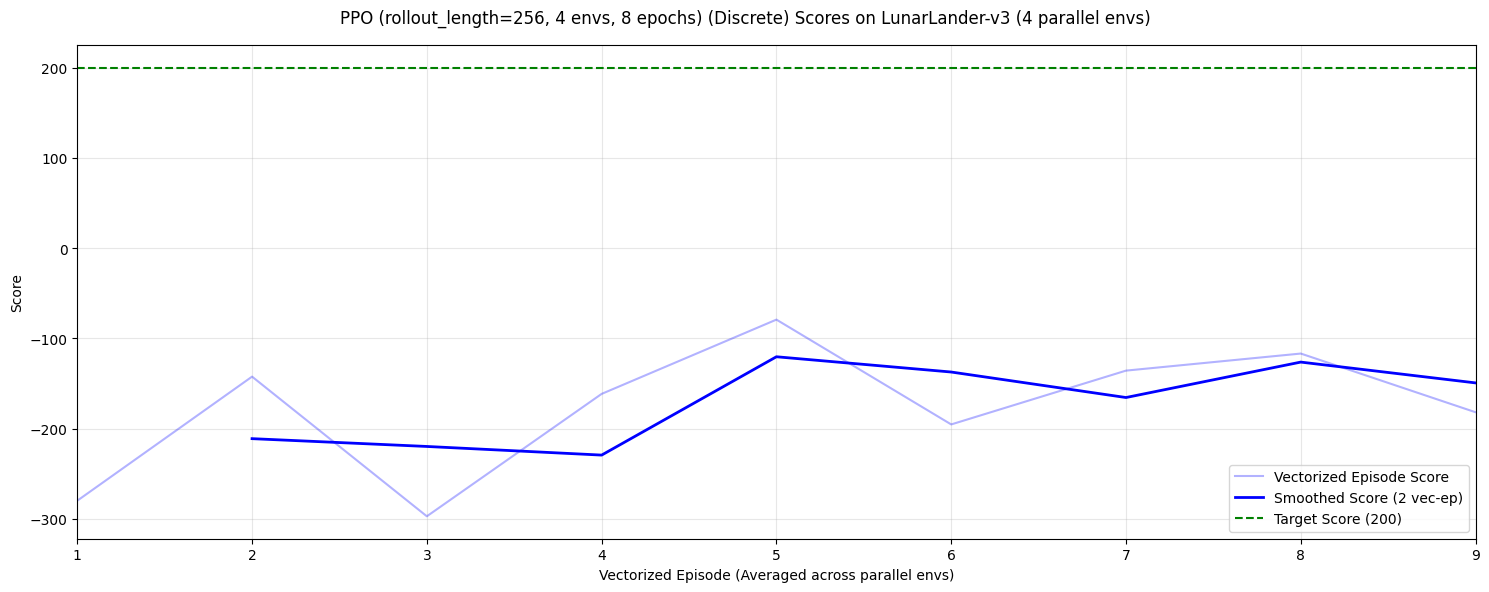

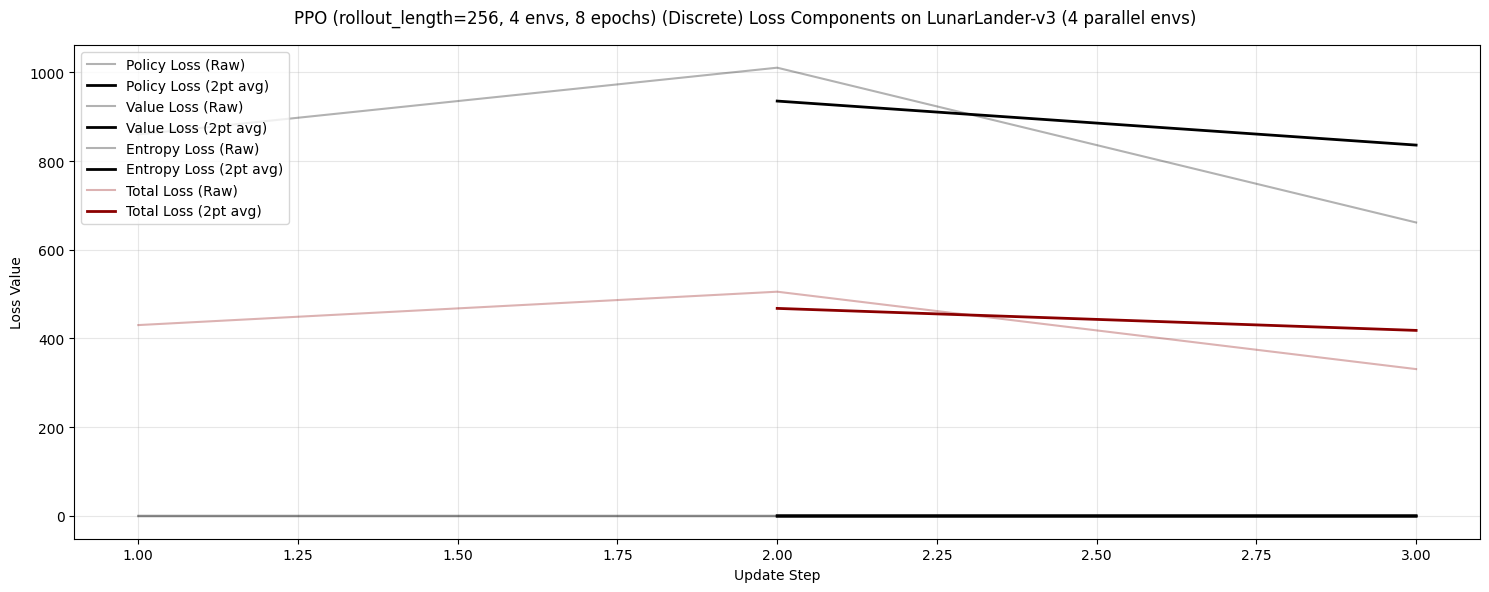

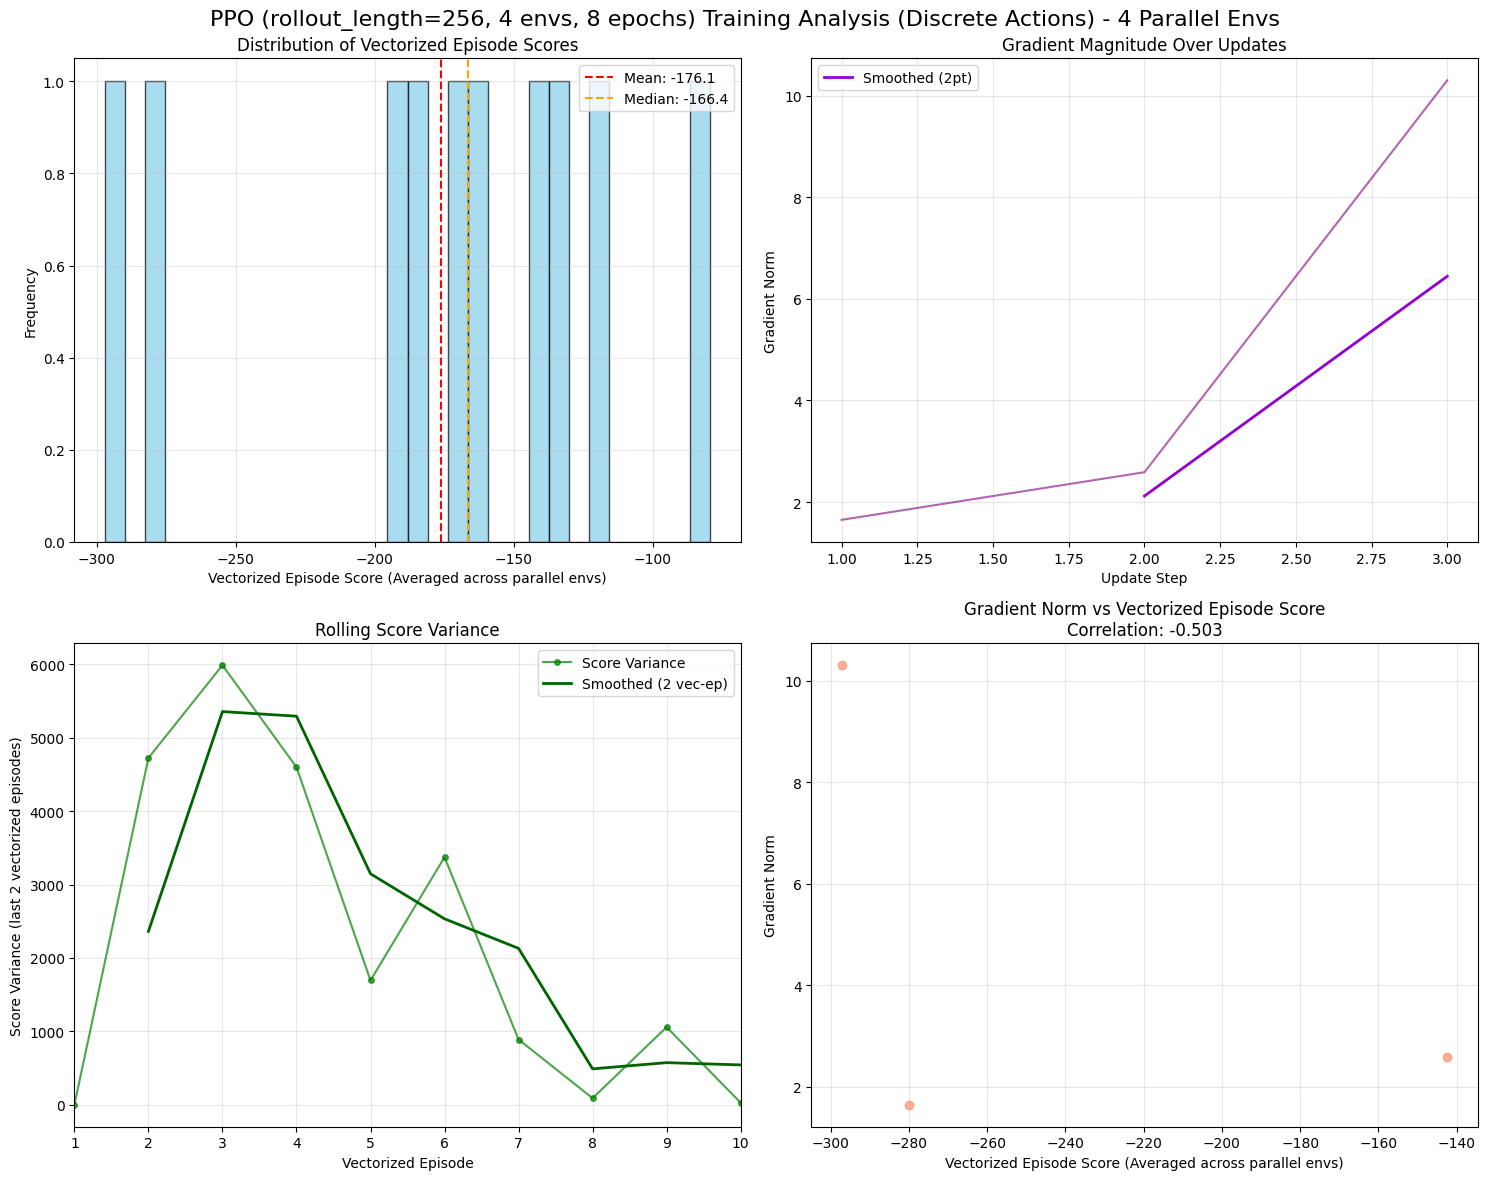


--- PPO (rollout_length=256, 4 envs, 8 epochs) Training Statistics (Discrete) ---
Vectorized Episode Scores: μ=-176.14, σ=64.61
Recent Score Variance: 27.92
Gradient Norms: μ=4.8479, σ=3.8800
Total Update Steps: 3
Total Individual Episodes: 43 (across 4 parallel envs)
Vectorized Episodes Completed: 10
Score Variance History Length: 10

--- PPO (rollout_length=256, 4 envs, 8 epochs) Training Statistics (Discrete) ---
Vectorized Episode Scores: μ=-176.14, σ=64.61
Recent Score Variance: 27.92
Gradient Norms: μ=4.8479, σ=3.8800
Total Update Steps: 3
Total Individual Episodes: 43 (across 4 parallel envs)
Vectorized Episodes Completed: 10
Score Variance History Length: 10

🔍 DISCRETE PPO TRAINING ANALYSIS:
Average KL divergence: 0.010228
Average policy clip fraction: 9.1%
Average value clip fraction: 85.2%
Rollouts per vectorized episode: 0.3

✅ DISCRETE PPO TRAINING COMPLETED!
Final average score (last 2 vectorized episodes): -176.59
Network parameters: 9,445
Parallel environments: 4
Rollo

In [5]:
# Plot results for discrete PPO using vectorized plotting
from rl_utils import plot_vectorized_training_results, plot_vectorized_variance_analysis

plot_vectorized_training_results(
    discrete_ppo_scores, 
    discrete_ppo_agent.loss_history, 
    CONFIG, 
    "Discrete", 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show variance analysis
plot_vectorized_variance_analysis(
    discrete_ppo_agent, 
    discrete_ppo_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show advantage normalization statistics
variance_stats = discrete_ppo_agent.get_variance_stats()

print(f"\n--- PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs) Training Statistics (Discrete) ---")
print(f"Vectorized Episode Scores: μ={np.mean(discrete_ppo_scores):.2f}, σ={np.std(discrete_ppo_scores):.2f}")
print(f"Recent Score Variance: {variance_stats.get('recent_score_variance', 0.0):.2f}")
print(f"Gradient Norms: μ={variance_stats['gradient_norm_mean']:.4f}, σ={variance_stats['gradient_norm_std']:.4f}")
print(f"Total Update Steps: {discrete_ppo_agent.update_step}")
print(f"Total Individual Episodes: {discrete_ppo_agent.total_episodes} (across {CONFIG['num_envs']} parallel envs)")
print(f"Vectorized Episodes Completed: {discrete_ppo_agent.vectorized_episodes}")
print(f"Score Variance History Length: {len(discrete_ppo_agent.score_variance_history)}")

print(f"\n🔍 DISCRETE PPO TRAINING ANALYSIS:")
print(f"Average KL divergence: {variance_stats['kl_div_mean']:.6f}")
print(f"Average policy clip fraction: {variance_stats['policy_clip_fraction_mean']*100:.1f}%")
print(f"Average value clip fraction: {variance_stats['value_clip_fraction_mean']*100:.1f}%")
print(f"Rollouts per vectorized episode: {discrete_ppo_agent.update_step / max(1, discrete_ppo_agent.vectorized_episodes):.1f}")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_ppo_scores))
final_avg = np.mean(discrete_ppo_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ DISCRETE PPO TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} vectorized episodes): {final_avg:.2f}")
print(f"Network parameters: {discrete_ppo_agent.network.get_param_count():,}")
print(f"Parallel environments: {CONFIG['num_envs']}")
print(f"Rollout length: {CONFIG['rollout_length']} steps per environment")

In [6]:
# --- CONTINUOUS ACTION SPACE: PPO ---
print("Starting PPO training with CONTINUOUS actions...")

continuous_ppo_scores, continuous_ppo_losses, continuous_ppo_agent = train_ppo(
    is_continuous=True, 
    config=CONFIG
)


📹 Displaying 10 training videos (episodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):


📹 11 training videos available in videos/ppo_continuous_continuous


VecEp    8 | Score: -128.8 | AvgScore(2): -196.8 | Rollouts:    4 | PolicyLoss: -0.0104 | ValueLoss: 661.8575 | KL: 0.0111 | PClip%:  9.4 | VClip%: 85.4 | :  89%|████████▉ | 8/9 [00:23<00:02,  2.93s/vec-episode]



Continuous training completed in 23.8 seconds!
Vectorized episodes completed: 11 (averaged across 4 parallel envs)
Total individual episodes: 44
Total rollouts performed: 4
Final performance: -169.41 (last 2 vectorized episodes)
Total updates performed: 4
Updates per vectorized episode: 0.4
Updates per individual episode: 0.1
Average KL divergence: 0.009083
Average policy clip fraction: 7.4%
Average value clip fraction: 81.0%


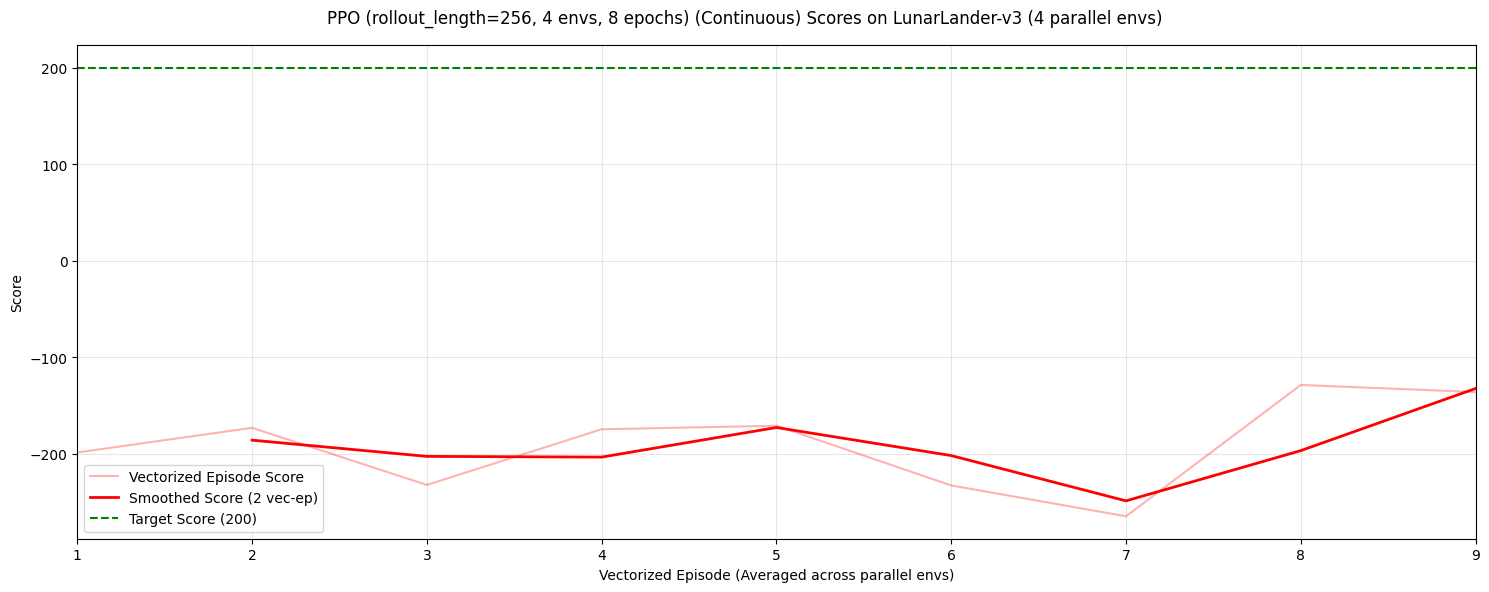

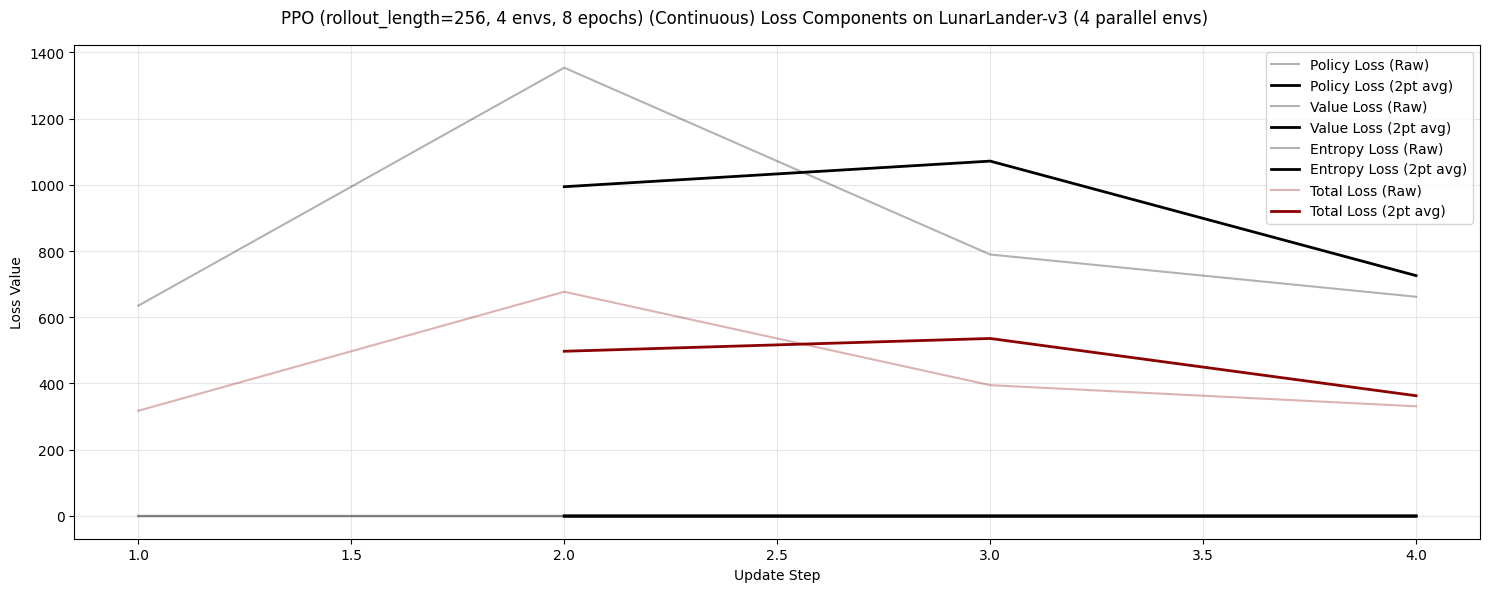

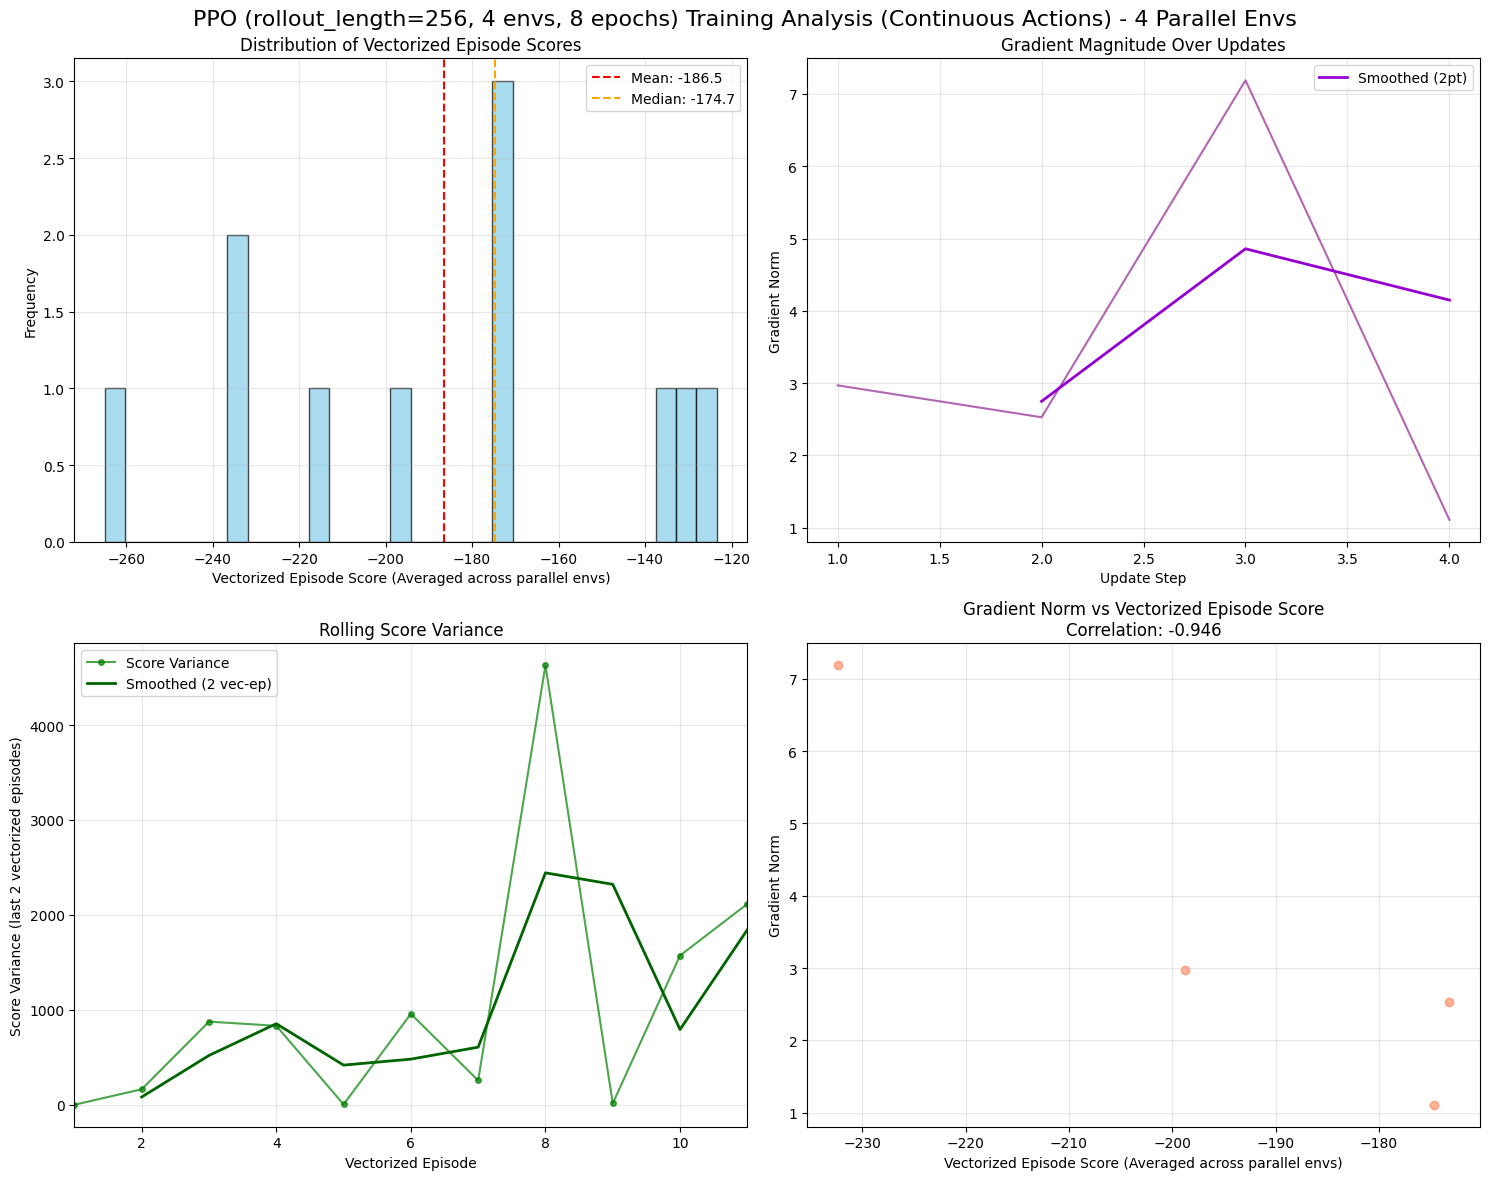


--- PPO (rollout_length=256, 4 envs, 8 epochs) Training Statistics (Continuous) ---
Vectorized Episode Scores: μ=-186.50, σ=44.51
Recent Score Variance: 2115.17
Gradient Norms: μ=3.4489, σ=2.2658
Total Update Steps: 4
Total Individual Episodes: 44 (across 4 parallel envs)
Vectorized Episodes Completed: 11
Score Variance History Length: 11

🔍 CONTINUOUS PPO TRAINING ANALYSIS:
Average KL divergence: 0.009083
Average policy clip fraction: 7.4%
Average value clip fraction: 81.0%
Rollouts per vectorized episode: 0.4

✅ CONTINUOUS PPO TRAINING COMPLETED!
Final average score (last 2 vectorized episodes): -169.41
Network parameters: 9,381
Parallel environments: 4
Rollout length: 256 steps per environment


In [7]:
# Plot results for continuous PPO using vectorized plotting
plot_vectorized_training_results(
    continuous_ppo_scores, 
    continuous_ppo_agent.loss_history, 
    CONFIG, 
    "Continuous", 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show variance analysis
plot_vectorized_variance_analysis(
    continuous_ppo_agent, 
    continuous_ppo_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show advantage normalization statistics
variance_stats = continuous_ppo_agent.get_variance_stats()

print(f"\n🔍 CONTINUOUS PPO TRAINING ANALYSIS:")
print(f"Average KL divergence: {variance_stats['kl_div_mean']:.6f}")
print(f"Average policy clip fraction: {variance_stats['policy_clip_fraction_mean']*100:.1f}%")
print(f"Average value clip fraction: {variance_stats['value_clip_fraction_mean']*100:.1f}%")
print(f"Rollouts per vectorized episode: {continuous_ppo_agent.update_step / max(1, continuous_ppo_agent.vectorized_episodes):.1f}")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_ppo_scores))
final_avg = np.mean(continuous_ppo_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ CONTINUOUS PPO TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} vectorized episodes): {final_avg:.2f}")
print(f"Network parameters: {continuous_ppo_agent.network.get_param_count():,}")
print(f"Parallel environments: {CONFIG['num_envs']}")
print(f"Rollout length: {CONFIG['rollout_length']} steps per environment")


COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits

📊 FINAL PERFORMANCE COMPARISON (last 2 vectorized episodes):
Method               Final Score  Score Std  Updates  Up/VecEp KL Div     Policy Clip % Value Clip % Parameters  
----------------------------------------------------------------------------------------------------------------------------------
Discrete PPO         -176.6       64.6       3        0.3      0.010228   9.1          85.2        9,445       
Continuous PPO       -169.4       44.5       4        0.4      0.009083   7.4          81.0        9,381       

📈 PPO-SPECIFIC ANALYSIS:
Discrete PPO:
  Score variance (last 2 vectorized episodes): 27.9
  Parallel environments: 4
  Rollout length: 256 steps per environment
  Epochs per update: 8
  Minibatch size: 64
  Average KL divergence: 0.010228
  Average policy clip fraction: 9.1%
  Average value clip fraction: 85.2%
Continuous PPO:
  Score variance (last 2 vectorized episodes): 2115.2
  Parallel environme

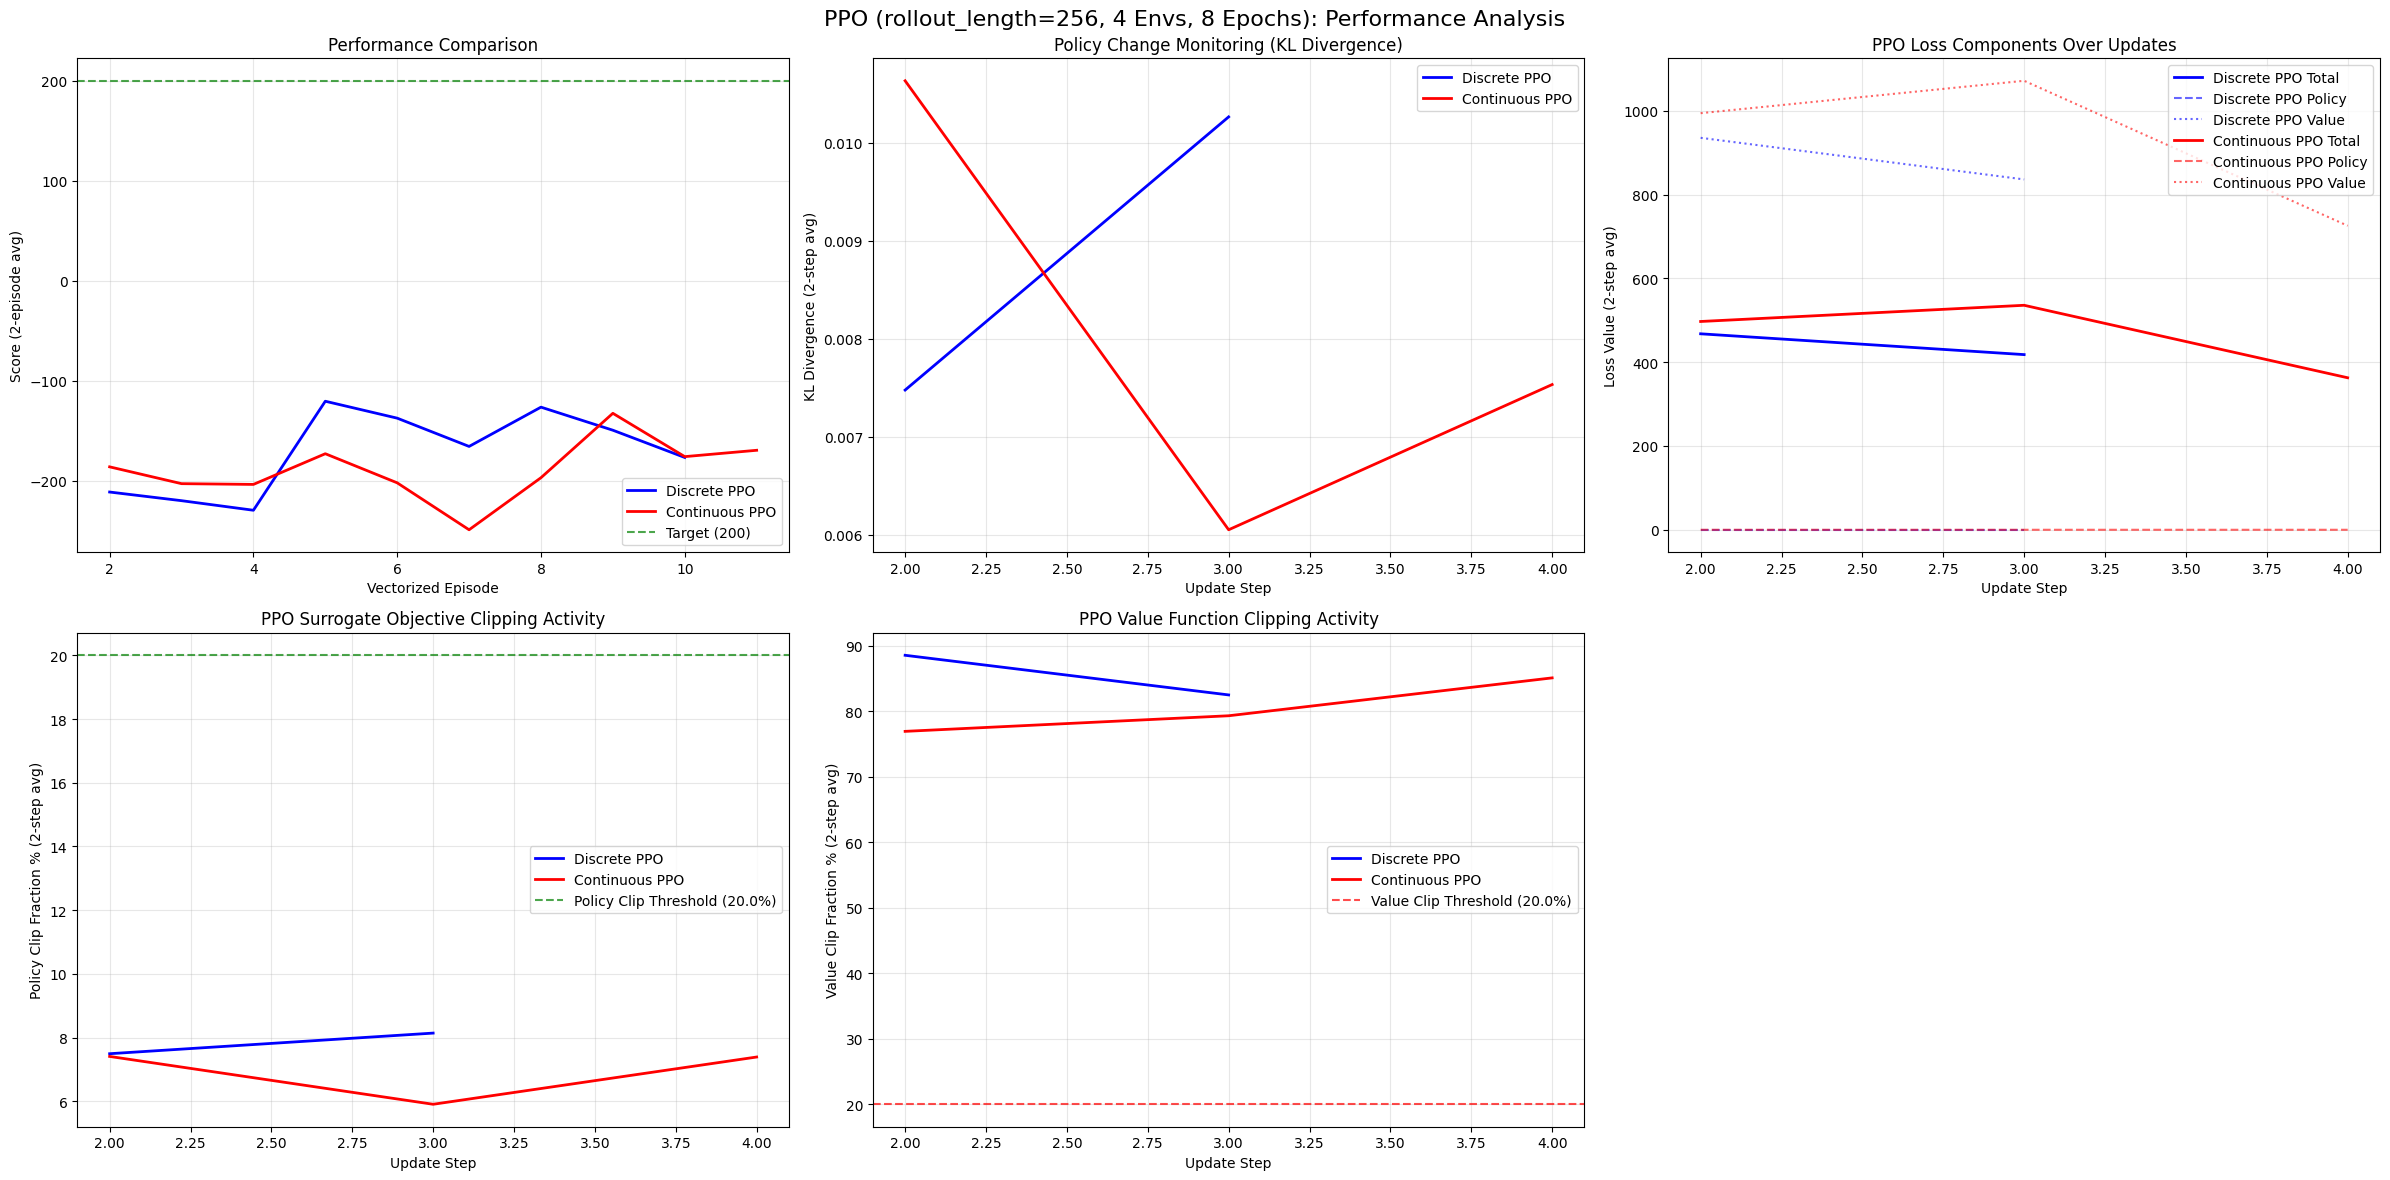

In [12]:
# --- COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits ---
import matplotlib.pyplot as plt
from rl_utils.visualization import get_moving_average

print(f"\n{'='*80}")
print(f"COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits")
print(f"{'='*80}")

# Collect experiment results
experiments = [
    ("Discrete PPO", discrete_ppo_scores, discrete_ppo_agent),
    ("Continuous PPO", continuous_ppo_scores, continuous_ppo_agent),
]

print(f"\n📊 FINAL PERFORMANCE COMPARISON (last {CONFIG['window_length']} vectorized episodes):")
print(f"{'Method':<20} {'Final Score':<12} {'Score Std':<10} {'Updates':<8} {'Up/VecEp':<8} {'KL Div':<10} {'Policy Clip %':<12} {'Value Clip %':<11} {'Parameters':<12}")
print("-" * 130)

for name, scores, agent in experiments:
    final_window_size = min(CONFIG["window_length"], len(scores))
    final_score = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    
    stats = agent.get_variance_stats()
    total_updates = getattr(agent, 'update_step', 0)
    updates_per_vectorized_episode = total_updates / max(1, agent.vectorized_episodes) if hasattr(agent, 'vectorized_episodes') else 0.0
    param_count = agent.network.get_param_count()
    
    kl_div = stats.get('kl_div_mean', 0.0)
    policy_clip_frac = stats.get('policy_clip_fraction_mean', 0.0) * 100
    value_clip_frac = stats.get('value_clip_fraction_mean', 0.0) * 100

    print(f"{name:<20} {final_score:<12.1f} {stats['score_std']:<10.1f} {total_updates:<8} {updates_per_vectorized_episode:<8.1f} {kl_div:<10.6f} {policy_clip_frac:<12.1f} {value_clip_frac:<11.1f} {param_count:<12,}")

print(f"\n📈 PPO-SPECIFIC ANALYSIS:")
for name, scores, agent in experiments:
    stats = agent.get_variance_stats()
    recent_score_var = stats.get('recent_score_variance', 0.0)
    
    print(f"{name}:")
    print(f"  Score variance (last {CONFIG['window_length']} vectorized episodes): {recent_score_var:.1f}")
    print(f"  Parallel environments: {CONFIG['num_envs']}")
    print(f"  Rollout length: {CONFIG['rollout_length']} steps per environment")
    print(f"  Epochs per update: {CONFIG['epochs']}")
    print(f"  Minibatch size: {CONFIG['minibatch_size']}")
    print(f"  Average KL divergence: {stats['kl_div_mean']:.6f}")
    print(f"  Average policy clip fraction: {stats['policy_clip_fraction_mean']*100:.1f}%")
    print(f"  Average value clip fraction: {stats['value_clip_fraction_mean']*100:.1f}%")

# Create PPO-specific analysis plots
# Create a larger figure with 6 subplots (2x3) to accommodate both clipping metrics
fig = plt.figure(figsize=(24, 12))

# Create subplots manually for better control
ax1 = plt.subplot(2, 3, 1)  # Scores
ax2 = plt.subplot(2, 3, 2)  # KL Divergence
ax3 = plt.subplot(2, 3, 3)  # Loss Components
ax4 = plt.subplot(2, 3, 4)  # Policy Clipping
ax5 = plt.subplot(2, 3, 5)  # Value Clipping
fig.suptitle(f'PPO (rollout_length={CONFIG["rollout_length"]}, {CONFIG["num_envs"]} Envs, {CONFIG["epochs"]} Epochs): Performance Analysis', fontsize=16)

colors = ['blue', 'red']
smoothing_window = CONFIG["window_length"]

# 1. Performance comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(scores) >= smoothing_window:
        smoothed, offset = get_moving_average(scores, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax1.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2)

ax1.axhline(y=CONFIG["target_score"], color='g', linestyle='--', label=f'Target ({CONFIG["target_score"]})', alpha=0.7)
ax1.set_xlabel('Vectorized Episode')
ax1.set_ylabel(f'Score ({smoothing_window}-episode avg)')
ax1.set_title('Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. KL Divergence tracking (PPO-specific)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.kl_divergence_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.kl_divergence_history, window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax2.plot(update_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax2.set_xlabel('Update Step')
ax2.set_ylabel(f'KL Divergence ({smoothing_window}-step avg)')
ax2.set_title('Policy Change Monitoring (KL Divergence)')
if CONFIG.get("target_kl"):
    ax2.axhline(y=CONFIG["target_kl"], color='r', linestyle='--', label=f'Target KL ({CONFIG["target_kl"]})', alpha=0.7)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. PPO Loss components over update steps
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.loss_history["total_loss"]) >= smoothing_window:
        # Plot total loss
        smoothed_total, offset = get_moving_average(agent.loss_history["total_loss"], window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed_total))
        ax3.plot(update_steps, smoothed_total, label=f'{name} Total', color=colors[i], linewidth=2)
        
        # Plot policy and value losses with transparency
        if len(agent.loss_history["policy_loss"]) >= smoothing_window:
            smoothed_policy, _ = get_moving_average(agent.loss_history["policy_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_policy, label=f'{name} Policy', color=colors[i], alpha=0.6, linestyle='--')
        
        if len(agent.loss_history["value_loss"]) >= smoothing_window:
            smoothed_value, _ = get_moving_average(agent.loss_history["value_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_value, label=f'{name} Value', color=colors[i], alpha=0.6, linestyle=':')

ax3.set_xlabel('Update Step')
ax3.set_ylabel(f'Loss Value ({smoothing_window}-step avg)')
ax3.set_title('PPO Loss Components Over Updates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Policy clip fraction over time (PPO-specific - Surrogate Objective Clipping)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.policy_clip_fraction_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.policy_clip_fraction_history, window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax4.plot(update_steps, [x*100 for x in smoothed], label=name, color=colors[i], linewidth=2)

ax4.set_xlabel('Update Step')
ax4.set_ylabel(f'Policy Clip Fraction % ({smoothing_window}-step avg)')
ax4.set_title('PPO Surrogate Objective Clipping Activity')
ax4.axhline(y=CONFIG["clip_epsilon"]*100, color='g', linestyle='--', 
           label=f'Policy Clip Threshold ({CONFIG["clip_epsilon"]*100:.1f}%)', alpha=0.7)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Value clip fraction over time (PPO-specific - Value Function Clipping)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.value_clip_fraction_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.value_clip_fraction_history, window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax5.plot(update_steps, [x*100 for x in smoothed], label=name, color=colors[i], linewidth=2)

ax5.set_xlabel('Update Step')
ax5.set_ylabel(f'Value Clip Fraction % ({smoothing_window}-step avg)')
ax5.set_title('PPO Value Function Clipping Activity')
ax5.axhline(y=CONFIG["value_clip_epsilon"]*100, color='r', linestyle='--', 
           label=f'Value Clip Threshold ({CONFIG["value_clip_epsilon"]*100:.1f}%)', alpha=0.7)
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()